In [1]:
import os
import sys

cwd = os.getcwd()
sys.path.append(os.path.abspath(".."))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from data.data_preprocessing import load_and_preprocess

/Users/khangdo/Desktop/sentiment classification project/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
train, val, test = load_and_preprocess(train_sample_size=100000, val_sample_size=2000)

In [4]:
train.head()

,label,title,text
0,1,Einstein: His Life Revealed,walter isaacson has clearly covered the bases ...
1,0,Totally unreliable measuring directions,the examples of things that can be built are v...
2,1,It's Not Just About the Book,i just finished reading the book as the tour d...
3,0,Playing in the dark,be careful buying this light the invoice and o...
4,0,"Rose-flavored Water, NOT Rosewater",if all you're after is rose flavor for cooking...


In [5]:
print(f"Training size: {len(train)}")
print(f"Validation size: {len(val)}")
print(f"Test size: {len(test)}")

Training size: 100000
Validation size: 2000
Test size: 180000


In [6]:
from gensim.models import Word2Vec

sentences = [text.split() for text in train["text"]]  # List of tokenized sentences

word2vec_model = Word2Vec(
    sentences=sentences,
    vector_size=100,        # Embedding dimension
    window=5,               # Context window
    min_count=1,           # Ignore words with frequency < min_count
    workers=4,             # Number of CPU cores
    epochs=10
)

In [7]:
def tokenize_with_gensim_vocab(texts, word2vec_model, max_length=50, unk_token="<UNK>"):
    """
    Tokenize texts using Word2Vec model's vocabulary
    """
    # Get vocabulary mapping
    word_to_id = word2vec_model.wv.key_to_index.copy()
    
    # Add special tokens if needed
    vocab_size = len(word_to_id)
    if unk_token not in word_to_id:
        word_to_id[unk_token] = vocab_size
        vocab_size += 1
    
    # Add padding token
    pad_token = "<PAD>"
    if pad_token not in word_to_id:
        word_to_id[pad_token] = vocab_size
        vocab_size += 1
    
    unk_id = word_to_id[unk_token]
    pad_id = word_to_id[pad_token]
    
    sequences = []
    
    for text in texts:
        # Basic tokenization (you can make this more sophisticated)
        tokens = text.lower().split()
        
        # Convert to indices
        indices = []
        for token in tokens:
            if token in word_to_id:
                indices.append(word_to_id[token])
            else:
                indices.append(unk_id)  # Unknown token
        
        # Truncate or pad
        if len(indices) > max_length:
            indices = indices[:max_length]
        else:
            indices.extend([pad_id] * (max_length - len(indices)))
        
        sequences.append(indices)
    
    return np.array(sequences), word_to_id

# Usage
sequences, word_to_id_gensim = tokenize_with_gensim_vocab(
    train["text"].tolist(), 
    word2vec_model, 
    max_length=50
)
print(f"Tokenized sequences shape: {sequences.shape}")
print(f"Vocabulary size: {len(word_to_id_gensim)}")

Tokenized sequences shape: (100000, 50)
Vocabulary size: 175623


In [8]:
def create_complete_gensim_pipeline(train_texts, val_texts, test_texts, 
                                  train_labels, val_labels, test_labels,
                                  word2vec_model, max_length=50):
    """
    Complete pipeline using Gensim Word2Vec model
    """
    print("=== GENSIM WORD2VEC PIPELINE ===")
    
    # 1. Tokenize all texts
    print("Tokenizing texts...")
    X_train, word_to_id = tokenize_with_gensim_vocab(train_texts, word2vec_model, max_length)
    X_val, _ = tokenize_with_gensim_vocab(val_texts, word2vec_model, max_length)
    X_test, _ = tokenize_with_gensim_vocab(test_texts, word2vec_model, max_length)
    
    # 2. Create embedding matrix
    print("Creating embedding matrix...")
    vocab_size = len(word_to_id)
    embedding_dim = word2vec_model.vector_size
    
    embedding_matrix = np.zeros((vocab_size, embedding_dim), dtype=np.float32)
    
    # Fill with Word2Vec vectors
    found_words = 0
    for word, idx in word_to_id.items():
        if word in word2vec_model.wv:
            embedding_matrix[idx] = word2vec_model.wv[word]
            found_words += 1
        else:
            # Random for special tokens like <UNK>, <PAD>
            embedding_matrix[idx] = np.random.normal(0, 0.1, embedding_dim)
    
    print(f"Found embeddings for {found_words}/{vocab_size} words")
    
    # 3. Convert labels
    y_train = np.array(train_labels, dtype=np.float32)
    y_val = np.array(val_labels, dtype=np.float32)
    y_test = np.array(test_labels, dtype=np.float32)
    
    print(f"Data shapes:")
    print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
    print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
    
    return {
        'X_train': X_train, 'y_train': y_train,
        'X_val': X_val, 'y_val': y_val, 
        'X_test': X_test, 'y_test': y_test,
        'embedding_matrix': embedding_matrix,
        'word_to_id': word_to_id,
        'vocab_size': vocab_size,
        'embedding_dim': embedding_dim
    }

# Usage
data = create_complete_gensim_pipeline(
    train["text"].tolist(), val["text"].tolist(), test["text"].tolist(),
    train["label"].tolist(), val["label"].tolist(), test["label"].tolist(),
    word2vec_model,
    max_length=50
)

=== GENSIM WORD2VEC PIPELINE ===
Tokenizing texts...
Creating embedding matrix...
Found embeddings for 175621/175623 words
Data shapes:
X_train: (100000, 50), y_train: (100000,)
X_val: (2000, 50), y_val: (2000,)
X_test: (180000, 50), y_test: (180000,)


 CREATING CUSTOM DEEP BIDIRECTIONAL RNN WITH TENSORFLOW

 BIDIRECTIONAL RNN MODEL ARCHITECTURE:
Input: (batch_size, 50) - Token sequences
Embedding: 175623 -> 100 (Word2Vec frozen)
BRNN 1: 100 -> 64*2 = 128 (Custom bidirectional)
BRNN 2: 128 -> 32*2 = 64 (Custom bidirectional)
Dense: 64 -> 32 (ReLU)
Output: 32 -> 1 (Sigmoid)
Merge mode: concat
Total parameters: 17,690,109
Note: BRNN has ~2x parameters compared to unidirectional RNN

 TRAINING BIDIRECTIONAL RNN
Training samples: 100000
Validation samples: 2000
Batch size: 32
Learning rate: 0.001
Sequence length: 50
Epoch 1/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 183s 57ms/step - accuracy: 0.7451 - loss: 0.4982 - val_accuracy: 0.8425 - val_loss: 0.3422 - learning_rate: 0.0010
Epoch 2/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 164s 53ms/step - accuracy: 0.8508 - loss: 0.3461 - val_accuracy: 0.8625 - val_loss: 0.3234 - learning_rate: 0.0010
Epoch 3/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 180s 58ms/step - accuracy: 0.8669 - loss: 0.3129 - val_accuracy: 0.8670 -

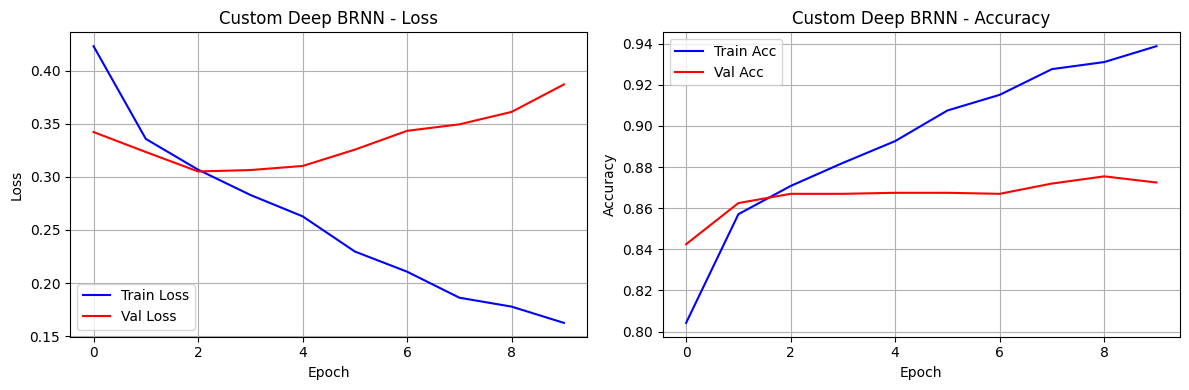


 ANALYZING BIDIRECTIONAL RNN INTERNALS
Embedding output shape: (1, 50, 100)
Sample embedding (first 5 dims): [-0.12269875 -1.3485342   4.475255    1.9728168  -1.8002095 ]
BRNN1 output shape: (1, 50, 128)
Note: Shape doubled due to bidirectional concatenation
BRNN1 output range: [-0.9944, 0.9977]
BRNN2 output shape: (1, 64)
BRNN2 output range: [-0.9260, 0.9289]
Final prediction: 0.9983

 BIDIRECTIONAL RNN CHARACTERISTICS:
• Processes sequence in BOTH directions
• Forward: past → future context
• Backward: future → past context
• Combines both for richer representation
• Better for sentiment analysis (can see full context)

 EVALUATING CUSTOM BRNN MODEL
Test Loss: 0.3605
Test Accuracy: 0.8685

Classification Report:
              precision    recall  f1-score   support

    Negative       0.88      0.85      0.87     90000
    Positive       0.86      0.89      0.87     90000

    accuracy                           0.87    180000
   macro avg       0.87      0.87      0.87    180000
wei

In [9]:
from src.BRNN import main_custom_deep_brnn
model, history = main_custom_deep_brnn(data)